# Sprint 機械学習スクラッチ　ロジスティック回帰

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

ロジスティック回帰のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

以下に雛形を用意してあります。このScratchLogisticRegressionクラスにコードを書き加えていってください。推定関係のメソッドは線形回帰と異なり、ラベルを出力するpredictメソッドと、確率を出力するpredict_probaメソッドの2種類を作成します。

In [57]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    def __init__(self, num_iter, lr, lam, bias=None, verbose=None):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.lam = lam
        self.bias = bias
        self.verbose = verbose
        # パラメーターと予測値の初期化
        self.coef_ = 0
        self.h0 = 0
        self.h0_val = 0
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter+1)
        self.val_loss = np.zeros(self.iter+1)
        # yのカテゴリ最大値、最小値の初期化
        self.y_max = 0
        self.y_min = 0

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """

        # yの一次元化
        y = y.ravel()
        y_val = y_val.ravel()
        
        # yのカテゴリ最大値、最小値を取得
        self.y_max = y.max()
        self.y_min = y.min()
        # yの０、１化(今回の題材は最大３分類のため、それに対応)
        if y.max()==2:
            y = np.where(y==2, 1, 0)
            y_val = np.where(y_val==2, 1, 0)
        
        # 切片列を追加（切片の有無を選べる）
        if not self.bias:   
            X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
            X_val = np.concatenate([np.ones([X_val.shape[0], 1]), X_val], axis=1)
        
        #パラメーターの設定（平均０、分散１の正規分布）
        self.coef_ = np.random.normal(0, 1, X.shape[1])
        
        for iter_count in range(self.iter):
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print("{}回目の学習".format(iter_count))
            
            # 過程関数、valも同時に更新
            _logistic_hypothesis(self, X, X_val)
            
            # lossの記録（初期値〜最後の更新前まで）
            loss_cal(self, iter_count, y, y_val)
            
            # 最急降下法
            # self.coef_の更新
            _gradient_descent(self, X, y, iter_count)
        
        # 最終的なlossを記録
        loss_cal(self, self.iter, y, y_val)

        return
    

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # カテゴリ最大値、最小値に対応させるために分岐
        if self.y_max == 2:
            if self.y_min == 1:
                return np.where(self.predict_proba(X)<0.5, 1, 2)
            else:
                return np.where(self.predict_proba(X)<0.5, 0, 2)
        else:
            return  np.where(self.predict_proba(X)<0.5, 0, 1)
        
        
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        h : 次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # バイアスあり
        if not self.bias:   
            h_liine = np.dot(X, self.coef_[1:].T)
            h = 1 / (1+np.exp(-h_liine))
        
        # バイアスなし
        else:
            h_liine = np.dot(X, self.coef_.T)
            h = 1 / (1+np.exp(-h_liine))

        return h

# 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。

ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。

In [58]:
def _logistic_hypothesis(self, X, X_val=None):
    """
    線形の仮定関数を計算する

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
      
    h_line : 次の形のndarray, shape (n_samples)
      trainの線型結合 
      
    h_line_val : 次の形のndarray, shape (n_samples)
      valの線型結合 
    
    Attributes
    ----------
      
    self.coef_ : 次の形のndarray, shape (n_features)
      Xに対するパラメーター 
    
    self.h0 : 次の形のndarray, shape (n_samples)
      シグモイド関数によるtrainの予測値（過程関数）
      
    self.h0_val : 次の形のndarray, shape (n_samples)
      シグモイド関数によるvalの予測値（過程関数）

    """
    # Xの過程関数
    # 線型結合
    h_liine = np.dot(X, self.coef_.T)
    # シグモイド関数化
    self.h0 = 1 / (1+np.exp(-h_liine))
    
    
    # X_valの過程関数
    # 線型結合
    h_liine_val = np.dot(X_val, self.coef_.T)
    # シグモイド関数化
    self.h0_val = 1 / (1+np.exp(-h_liine_val))
    
    return

# 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

In [59]:
def _gradient_descent(self, X, y, iter_count):
    """
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    
    y : 次の形のndarray, shape (n_samples)
      学習データの結果
      
    self.lam : float
      正則化パラメータ
      
    self.lr : float
      学習率
    
    self.coef_ : 次の形のndarray, shape (n_features)
      Xに対するパラメーター
      
    coef_reg : 次の形のndarray, shape (n_features)
      正則化に用いるパラメーター
    
    self.h0 : 次の形のndarray, shape (n_samples)
      シグモイド関数によるtrainの予測値（過程関数）
    
    Returns
    -------
    self.theta_ : 次の形のndarray, shape (n_samples, 1)
      線形の仮定関数による推定結果
      
    """
    # 傾き、j=0,1で正則化の有無が異なる
    # そのため、正則化項のcoef_[0]を０にする
    coef_reg = self.coef_.copy()
    coef_reg[0] = 0
    delta = (np.dot(X.T, (self.h0 - y)) + self.lam*coef_reg)/X.shape[0]
    
    # 更新式
    self.coef_ = self.coef_ - self.lr*delta
    
    return

 # 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。

仮定関数 hθ(x) の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

# 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。

なお、この数式には正則化項が含まれています。

＊数式が見切れる場合、DIVERを全画面にして御覧ください。

In [60]:
def loss_cal(self, iter_count, y, y_val=None):
    """
    損失関数の計算と記録

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    cost : numpy.float
      平均二乗誤差
    """
    # 傾き、j=0,1で正則化の有無が異なる
    # そのため、正則化項のcoef_[0]を０にする
    coef_reg = self.coef_.copy()
    coef_reg[0] = 0
    
    #logないがゼロにならないようにする
    epsilon = 1e-5
    
    #trainのloss
    loss = ((-y * np.log(self.h0+epsilon) -
               (1-y) * np.log(1-self.h0+epsilon)).sum() +
               self.lam/2*(coef_reg**2).sum()) / y.shape[0]
    self.loss[iter_count] = loss
    
    #valのloss
    val_loss = ((-y_val * np.log(self.h0_val+epsilon) -
                    (1-y_val) * np.log(1-self.h0_val+epsilon)).sum() +
                    self.lam/2*(coef_reg**2).sum()) / y.shape[0]
    self.val_loss[iter_count] = val_loss

    return

# 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [61]:
from sklearn.datasets import load_iris
iris = load_iris()
X = pd.DataFrame(data=iris.data, columns=iris.feature_names)
y = pd.DataFrame(data=iris.target, columns=['species'])
df = pd.concat([X, y], axis=1)
# 抜き出し
df_2ex =df.query('species == 1 | species == 2')[["sepal length (cm)", "petal length (cm)", 'species']]
X = df_2ex[["sepal length (cm)", "petal length (cm)",]]
y = df_2ex[["species"]]
# ndarray変換
X_array = X.values
# yに関して一次元化（グラフ化で必要）
y_array = np.ravel(y.values)
# 分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X_array, y_array, test_size=0.25, random_state=0)
# 標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)

In [62]:
# 学習
slreg = ScratchLogisticRegression(5000, 0.005, 0.001)
slreg.fit(X_train_std, y_train, X_valid_std, y_valid)
y_valid_predict = slreg.predict(X_valid_std)

In [63]:
y_valid_predict

array([2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 1, 1])

In [64]:
y_valid

array([1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 2, 1])

In [65]:
# 正解率
print("正解率：", accuracy_score(y_valid, y_valid_predict))
# 適合率
print("適合率：", precision_score(y_valid, y_valid_predict))
# Recall（再現率）
print("再現率：", recall_score(y_valid, y_valid_predict))
# F値
print("F値：", f1_score(y_valid, y_valid_predict))
# 混同行列
print("混同行列\n", confusion_matrix(y_valid, y_valid_predict))

正解率： 0.8
適合率： 0.9
再現率： 0.6923076923076923
F値： 0.7826086956521738
混同行列
 [[ 9  4]
 [ 1 11]]


# 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

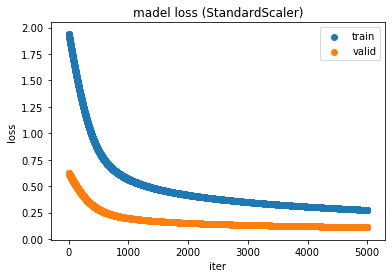

In [66]:
# グラフ化
iter_list = [i for i in range(slreg.iter+1)]
plt.scatter(iter_list, slreg.loss, label="train")
plt.scatter(iter_list, slreg.val_loss, label="valid")
plt.ylabel('loss')
plt.xlabel('iter')
plt.title('madel loss (StandardScaler)')
plt.legend();

# 【問題7】決定領域の可視化
決定領域を可視化してください。

In [67]:
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel',
                    ylabel='ylabel', target_names=['setosa', 'versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['green', 'red', 'blue']
    contourf_color = ['white', 'pink', 'skyblue']
    # クラスの長さをクラス数
    n_class = len(set(y))

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step),
                                    np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # contourf_color、scatter_color、target_namesをクラス数に応じて変化
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap([contourf_color[n] for n in set(y)]))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80,
                    color=scatter_color[target],label=target_names[target], marker='o')
    patches = [mpatches.Patch(color=scatter_color[n], label=target_names[n]) for n in set(y)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

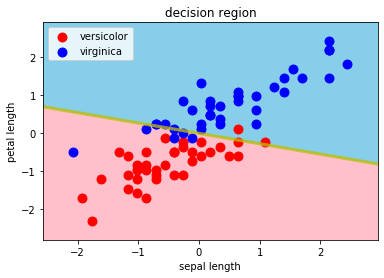

In [68]:
decision_region(X_train_std, y_train, model=slreg, step=0.01, title='decision region',
                xlabel="sepal length", ylabel="petal length")

# 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。

In [46]:
import pickle
# 保存
with open('sprint3-work1_param.pickle', 'wb') as f:
    pickle.dump(slreg.coef_, f)

In [47]:
# 出力
with open('sprint3-work1_param.pickle', 'rb') as f:
    best_param = pickle.load(f)

In [48]:
# 一致しているか確認
print(best_param == slreg.coef_)

[ True  True  True]


# バイアスなし、学習の記録

In [69]:
# 学習
slreg_no = ScratchLogisticRegression(5000, 0.005, 0.001, True, True)
slreg_no.fit(X_train_std, y_train, X_valid_std, y_valid)
y_valid_predict_no = slreg_no.predict(X_valid_std)

0回目の学習
1回目の学習
2回目の学習
3回目の学習
4回目の学習
5回目の学習
6回目の学習
7回目の学習
8回目の学習
9回目の学習
10回目の学習
11回目の学習
12回目の学習
13回目の学習
14回目の学習
15回目の学習
16回目の学習
17回目の学習
18回目の学習
19回目の学習
20回目の学習
21回目の学習
22回目の学習
23回目の学習
24回目の学習
25回目の学習
26回目の学習
27回目の学習
28回目の学習
29回目の学習
30回目の学習
31回目の学習
32回目の学習
33回目の学習
34回目の学習
35回目の学習
36回目の学習
37回目の学習
38回目の学習
39回目の学習
40回目の学習
41回目の学習
42回目の学習
43回目の学習
44回目の学習
45回目の学習
46回目の学習
47回目の学習
48回目の学習
49回目の学習
50回目の学習
51回目の学習
52回目の学習
53回目の学習
54回目の学習
55回目の学習
56回目の学習
57回目の学習
58回目の学習
59回目の学習
60回目の学習
61回目の学習
62回目の学習
63回目の学習
64回目の学習
65回目の学習
66回目の学習
67回目の学習
68回目の学習
69回目の学習
70回目の学習
71回目の学習
72回目の学習
73回目の学習
74回目の学習
75回目の学習
76回目の学習
77回目の学習
78回目の学習
79回目の学習
80回目の学習
81回目の学習
82回目の学習
83回目の学習
84回目の学習
85回目の学習
86回目の学習
87回目の学習
88回目の学習
89回目の学習
90回目の学習
91回目の学習
92回目の学習
93回目の学習
94回目の学習
95回目の学習
96回目の学習
97回目の学習
98回目の学習
99回目の学習
100回目の学習
101回目の学習
102回目の学習
103回目の学習
104回目の学習
105回目の学習
106回目の学習
107回目の学習
108回目の学習
109回目の学習
110回目の学習
111回目の学習
112回目の学習
113回目の学習
114回目の学習
115回目の学習
116回目の学習
117回目の学習
118回目の学習
119回目の学習
120回目の学習
121回目の学習
122回目の学習
123

1600回目の学習
1601回目の学習
1602回目の学習
1603回目の学習
1604回目の学習
1605回目の学習
1606回目の学習
1607回目の学習
1608回目の学習
1609回目の学習
1610回目の学習
1611回目の学習
1612回目の学習
1613回目の学習
1614回目の学習
1615回目の学習
1616回目の学習
1617回目の学習
1618回目の学習
1619回目の学習
1620回目の学習
1621回目の学習
1622回目の学習
1623回目の学習
1624回目の学習
1625回目の学習
1626回目の学習
1627回目の学習
1628回目の学習
1629回目の学習
1630回目の学習
1631回目の学習
1632回目の学習
1633回目の学習
1634回目の学習
1635回目の学習
1636回目の学習
1637回目の学習
1638回目の学習
1639回目の学習
1640回目の学習
1641回目の学習
1642回目の学習
1643回目の学習
1644回目の学習
1645回目の学習
1646回目の学習
1647回目の学習
1648回目の学習
1649回目の学習
1650回目の学習
1651回目の学習
1652回目の学習
1653回目の学習
1654回目の学習
1655回目の学習
1656回目の学習
1657回目の学習
1658回目の学習
1659回目の学習
1660回目の学習
1661回目の学習
1662回目の学習
1663回目の学習
1664回目の学習
1665回目の学習
1666回目の学習
1667回目の学習
1668回目の学習
1669回目の学習
1670回目の学習
1671回目の学習
1672回目の学習
1673回目の学習
1674回目の学習
1675回目の学習
1676回目の学習
1677回目の学習
1678回目の学習
1679回目の学習
1680回目の学習
1681回目の学習
1682回目の学習
1683回目の学習
1684回目の学習
1685回目の学習
1686回目の学習
1687回目の学習
1688回目の学習
1689回目の学習
1690回目の学習
1691回目の学習
1692回目の学習
1693回目の学習
1694回目の学習
1695回目の学習
1696回目の学習
1697回目の学習
1698回目の学習
1699回目の学習


2503回目の学習
2504回目の学習
2505回目の学習
2506回目の学習
2507回目の学習
2508回目の学習
2509回目の学習
2510回目の学習
2511回目の学習
2512回目の学習
2513回目の学習
2514回目の学習
2515回目の学習
2516回目の学習
2517回目の学習
2518回目の学習
2519回目の学習
2520回目の学習
2521回目の学習
2522回目の学習
2523回目の学習
2524回目の学習
2525回目の学習
2526回目の学習
2527回目の学習
2528回目の学習
2529回目の学習
2530回目の学習
2531回目の学習
2532回目の学習
2533回目の学習
2534回目の学習
2535回目の学習
2536回目の学習
2537回目の学習
2538回目の学習
2539回目の学習
2540回目の学習
2541回目の学習
2542回目の学習
2543回目の学習
2544回目の学習
2545回目の学習
2546回目の学習
2547回目の学習
2548回目の学習
2549回目の学習
2550回目の学習
2551回目の学習
2552回目の学習
2553回目の学習
2554回目の学習
2555回目の学習
2556回目の学習
2557回目の学習
2558回目の学習
2559回目の学習
2560回目の学習
2561回目の学習
2562回目の学習
2563回目の学習
2564回目の学習
2565回目の学習
2566回目の学習
2567回目の学習
2568回目の学習
2569回目の学習
2570回目の学習
2571回目の学習
2572回目の学習
2573回目の学習
2574回目の学習
2575回目の学習
2576回目の学習
2577回目の学習
2578回目の学習
2579回目の学習
2580回目の学習
2581回目の学習
2582回目の学習
2583回目の学習
2584回目の学習
2585回目の学習
2586回目の学習
2587回目の学習
2588回目の学習
2589回目の学習
2590回目の学習
2591回目の学習
2592回目の学習
2593回目の学習
2594回目の学習
2595回目の学習
2596回目の学習
2597回目の学習
2598回目の学習
2599回目の学習
2600回目の学習
2601回目の学習
2602回目の学習


3408回目の学習
3409回目の学習
3410回目の学習
3411回目の学習
3412回目の学習
3413回目の学習
3414回目の学習
3415回目の学習
3416回目の学習
3417回目の学習
3418回目の学習
3419回目の学習
3420回目の学習
3421回目の学習
3422回目の学習
3423回目の学習
3424回目の学習
3425回目の学習
3426回目の学習
3427回目の学習
3428回目の学習
3429回目の学習
3430回目の学習
3431回目の学習
3432回目の学習
3433回目の学習
3434回目の学習
3435回目の学習
3436回目の学習
3437回目の学習
3438回目の学習
3439回目の学習
3440回目の学習
3441回目の学習
3442回目の学習
3443回目の学習
3444回目の学習
3445回目の学習
3446回目の学習
3447回目の学習
3448回目の学習
3449回目の学習
3450回目の学習
3451回目の学習
3452回目の学習
3453回目の学習
3454回目の学習
3455回目の学習
3456回目の学習
3457回目の学習
3458回目の学習
3459回目の学習
3460回目の学習
3461回目の学習
3462回目の学習
3463回目の学習
3464回目の学習
3465回目の学習
3466回目の学習
3467回目の学習
3468回目の学習
3469回目の学習
3470回目の学習
3471回目の学習
3472回目の学習
3473回目の学習
3474回目の学習
3475回目の学習
3476回目の学習
3477回目の学習
3478回目の学習
3479回目の学習
3480回目の学習
3481回目の学習
3482回目の学習
3483回目の学習
3484回目の学習
3485回目の学習
3486回目の学習
3487回目の学習
3488回目の学習
3489回目の学習
3490回目の学習
3491回目の学習
3492回目の学習
3493回目の学習
3494回目の学習
3495回目の学習
3496回目の学習
3497回目の学習
3498回目の学習
3499回目の学習
3500回目の学習
3501回目の学習
3502回目の学習
3503回目の学習
3504回目の学習
3505回目の学習
3506回目の学習
3507回目の学習


4349回目の学習
4350回目の学習
4351回目の学習
4352回目の学習
4353回目の学習
4354回目の学習
4355回目の学習
4356回目の学習
4357回目の学習
4358回目の学習
4359回目の学習
4360回目の学習
4361回目の学習
4362回目の学習
4363回目の学習
4364回目の学習
4365回目の学習
4366回目の学習
4367回目の学習
4368回目の学習
4369回目の学習
4370回目の学習
4371回目の学習
4372回目の学習
4373回目の学習
4374回目の学習
4375回目の学習
4376回目の学習
4377回目の学習
4378回目の学習
4379回目の学習
4380回目の学習
4381回目の学習
4382回目の学習
4383回目の学習
4384回目の学習
4385回目の学習
4386回目の学習
4387回目の学習
4388回目の学習
4389回目の学習
4390回目の学習
4391回目の学習
4392回目の学習
4393回目の学習
4394回目の学習
4395回目の学習
4396回目の学習
4397回目の学習
4398回目の学習
4399回目の学習
4400回目の学習
4401回目の学習
4402回目の学習
4403回目の学習
4404回目の学習
4405回目の学習
4406回目の学習
4407回目の学習
4408回目の学習
4409回目の学習
4410回目の学習
4411回目の学習
4412回目の学習
4413回目の学習
4414回目の学習
4415回目の学習
4416回目の学習
4417回目の学習
4418回目の学習
4419回目の学習
4420回目の学習
4421回目の学習
4422回目の学習
4423回目の学習
4424回目の学習
4425回目の学習
4426回目の学習
4427回目の学習
4428回目の学習
4429回目の学習
4430回目の学習
4431回目の学習
4432回目の学習
4433回目の学習
4434回目の学習
4435回目の学習
4436回目の学習
4437回目の学習
4438回目の学習
4439回目の学習
4440回目の学習
4441回目の学習
4442回目の学習
4443回目の学習
4444回目の学習
4445回目の学習
4446回目の学習
4447回目の学習
4448回目の学習


In [70]:
# 正解率
print("正解率：", accuracy_score(y_valid, y_valid_predict_no))
# 適合率
print("適合率：", precision_score(y_valid, y_valid_predict_no))
# Recall（再現率）
print("再現率：", recall_score(y_valid, y_valid_predict_no))
# F値
print("F値：", f1_score(y_valid, y_valid_predict_no))
# 混同行列
print("混同行列\n", confusion_matrix(y_valid, y_valid_predict_no))

正解率： 0.76
適合率： 0.8181818181818182
再現率： 0.6923076923076923
F値： 0.7500000000000001
混同行列
 [[ 9  4]
 [ 2 10]]


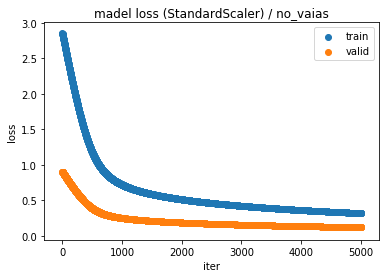

In [71]:
# グラフ化
iter_list_no = [i for i in range(slreg_no.iter+1)]
plt.scatter(iter_list_no, slreg_no.loss, label="train")
plt.scatter(iter_list_no, slreg_no.val_loss, label="valid")
plt.ylabel('loss')
plt.xlabel('iter')
plt.title('madel loss (StandardScaler) / no_vaias')
plt.legend();

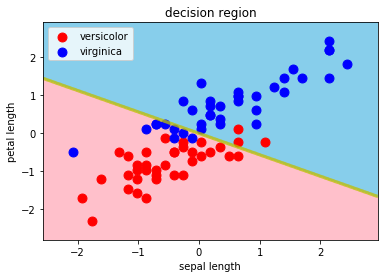

In [72]:
# 境界線の可視化
decision_region(X_train_std, y_train, model=slreg_no, step=0.01, title='decision region',
                xlabel="sepal length", ylabel="petal length")